## 0. Getting setup

In [1]:
import torch

pt_version = torch.__version__
print(f"[INFO] Current Pytorch Version: {pt_version} (should be 2.x+)")

if pt_version.split(".")[0] == "1":
    !pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    print("[INFO] PyTorch 2.x installed")
    import torch
    pt_version = torch.__version__
    print(f"[INFO] current Pytroch Version: {pt_version}")
else:
    print("[INFO] Pytorch 2.x installed you will be able to use the new features")
    

[INFO] Current Pytorch Version: 2.4.1+cu124 (should be 2.x+)
[INFO] Pytorch 2.x installed you will be able to use the new features


## 1. Get GPU info

In [2]:
# Make sure we're using a NVIDIA GPU
if torch.cuda.is_available():
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find("failed") >= 0:
    print("Not connected to a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

  # Get GPU name
  gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv
  gpu_name = gpu_name[1]
  GPU_NAME = gpu_name.replace(" ", "_") # remove underscores for easier saving
  print(f'GPU name: {GPU_NAME}')

  # Get GPU capability score
  GPU_SCORE = torch.cuda.get_device_capability()
  print(f"GPU capability score: {GPU_SCORE}")
  if GPU_SCORE >= (8, 0):
    print(f"GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available.")
  else:
    print(f"GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).")
  
  # Print GPU info
  print(f"GPU information:\n{gpu_info}")

else:
  print("PyTorch couldn't find a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

GPU name: NVIDIA_H100_NVL
GPU capability score: (9, 0)
GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available.
GPU information:
Mon Oct 21 16:17:28 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 NVL                On  |   00000000:01:00.0 Off |                    0 |
| N/A   41C    P0             98W /  400W |       4MiB /  95830MiB |      0%  

### 1.1 Globally set devices
The default device type can be set via:
* Context manager
* Globally

Previously, you could only set the default device type via:
* `tensor.to(device)`

Context manager:
* `with torch.device(device):`

In [3]:
import torch
 
device = "cuda" if torch.cuda.is_available() else "cpu"

with torch.device(device):
    layer = torch.nn.Linear(20, 30)
    print(f"Layer weigths are on device: {layer.weight.device}")
    print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

Layer weigths are on device: cuda:0
Layer creating data on device: cuda:0


Globally:
* `torch.set_default_device(device)`

In [4]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.set_default_device(device)

layer = torch.nn.Linear(20, 30)
print(f"Layer weights are on device: {layer.weight.device}")
print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

Layer weights are on device: cuda:0
Layer creating data on device: cuda:0


In [5]:
import torch

device = "cpu"

torch.set_default_device(device)

layer = torch.nn.Linear(20, 30)
print(f"Layer weights are on device: {layer.weight.device}")
print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

Layer weights are on device: cpu
Layer creating data on device: cpu


# 2. Setting up experiments

* Model: ResNet50
* Data: CIFAIR10
* Eopch: 5 (single run) and 3x5 (multiple run)
* Batch size: 128
* Image size: 224
  

In [6]:
import torch, torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"

## 2.1 Create model and transforms
Ge the weights and transforms for ResNet50 use the following:
* `model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2`
* `transforms = model_weigths.transforms()`

(Once we have the weights, we can get the appropriate transforms for the model)

In [7]:
model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
transforms = model_weights.transforms()

# Setup model
model = torchvision.models.resnet50(weights=model_weights)
# print([list(model.modules())])
print(model)

# Count the number of parameters
total_params = sum(
    param.numel() for param in model.parameters()
) 
trainable_params = sum(
    param.numel() for param in model.parameters() if param.requires_grad
) 

print(f"Total parameters: {total_params}, trainable parameters; {trainable_params}")
print(f"Model transforms:\n{transforms}")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Turn the code to function that can be replicated later, and adjust the last layer's (model.fc) output features to match the number fo the classes in CIFAR10 (10)

In [8]:
def create_model(num_class=10):
    model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
    transforms = model_weights.transforms()
    model = torchvision.models.resnet50(weights=model_weights)

    # Adjust the number of output features in model to match the number of class
    model.fc = torch.nn.Linear(in_features=2048, out_features=num_class)

    return model, transforms
model, transforms = create_model()

## 2.2 Speedups are most noticeable when a large portion of the GPU is being used
The majority of relative speedups when as much data as possible is on the GPU

This can be achieved by:
* **Increasing the batch size**: More samplers per batch means more smaples on the GPU, for example, using a batch size of 256 instead of 32
* **Increasing data size**: For example, using larger image size, 224x224 instead of 32x32. A larger data size means that more tensor operations will be happening on the GPU
* **Increasing model size**: For example, using larger model such as ResNet101 instead of ResNet50. A larger model means that more tensor operations will be happening on the GPU
* **Decreasing data transfer**: For example, setting up all tensors to be on GPU memory, this minimizes the amount of data tansfer between the CPU and GPU

## 2.3 Checking the memory limits of our GPU
If the GPU has less memory , we may need to decrease the barch size or image size

We can check the memory availabel on our GPU using `torch.cuda.mem_get_info()`, it return a tuple of `(total_free_gpu_memory, total_gpu_memory)`

Where:
* `total_free_gpu_memory` is the amount of memory currently not being used on the GPU in bytes
* `total_gpu_memory` is the total amount of memory available on the GPU in bytes

In [9]:
total_free_gpu_memory, total_gpu_memory = torch.cuda.mem_get_info()
print(f"Total free GPU memory: {round(total_free_gpu_memory*1e-9, 3)} GB")
print(f"Total GPU memory: {round(total_gpu_memory*1e-9, 3)} GB")

Total free GPU memory: 99.202 GB
Total GPU memory: 99.861 GB


In [10]:
total_free_gpu_memory_gb = round(total_free_gpu_memory*1e-9, 3)
if total_free_gpu_memory_gb >= 16:
    BATCH_SIZE = 128
    IMAGE_SIZE = 224
    print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE}, image size {IMAGE_SIZE}")
else:
    BATCH_SIZE = 32
    IMAGE_SIZE = 128
    print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE}, image size {IMAGE_SIZE}")

GPU memory available is 99.202 GB, using batch size of 128, image size 224


adjust the `transforms` to use the respective `IMAGE_SIZE`

In [11]:
transforms.crop_size = IMAGE_SIZE
transforms.resize_size = IMAGE_SIZE
print(f"Updated data transforms: {transforms}")

Updated data transforms: ImageClassification(
    crop_size=224
    resize_size=224
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## 2.4 More potential speedupds with TF32
TF32 stands for TensorFloat-32, a data format which is a combination of 16-bit and 32-bit floating point numbers

If you are using a GPU with a compute capability score of 8.0 or above, you can enable TF32 by setting `torch.backends.cuda.matmul.allow_tf32=True`

> **_Note:_** TensorFloat32 is disabled by default (set to False) in PyTorch versions 1.12 onwards. This is because it may cause inconsistent results across different devices. Although this issue is not noticed for all use cases, it's worth knowing.

In [12]:
if GPU_SCORE >= (8, 0):
    print(f"[INFO] Using GPU with score: {GPU_SCORE}, enabling TensorFloat32 (TF32)")
    torch.backends.cuda.matmul.allow_tf32 = True
else:
    print(f"[INFO] Using GPU with score: {GPU_SCORE}, disabling TensorFloat32 (TF32)")
    torch.backends.cuda.matmul.allow_tf32 = False

[INFO] Using GPU with score: (9, 0), enabling TensorFloat32 (TF32)


## 2.5 Preparing datasets
Some info about CIFAR10 the CIFAR10 website:
* CIFAR10 is a dataset of 60,000 32x32 color images in 10 classes, with 6,000 images per class.
* There are 50,000 training images and 10,000 test images.
* The dataset contains 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

Although the original dataset consists of 32x32 images, we will use the `transform` we created earlier to resize them to 224x224

In [13]:
train_dataset = torchvision.datasets.CIFAR10(root='.',
                                             train=True,
                                             download=True,
                                             transform=transforms)
test_dataset = torchvision.datasets.CIFAR10(root='.',
                                            train=False,
                                            download=True,
                                            transform=transforms)
train_len = len(train_dataset)
test_len = len(test_dataset)
print(f"[INFO] Train dataset length: {train_len}")
print(f"[INFO] Test dataset length: {test_len}")

Files already downloaded and verified
Files already downloaded and verified
[INFO] Train dataset length: 50000
[INFO] Test dataset length: 10000


## 2.6 Create dataloaders
Data loading is the main bottleneck of machine learning code as in the tranfer speed from CPU to GPUaa

In [14]:
from torch.utils.data import DataLoader
import os
NUM_WORKERS = os.cpu_count()
print(f"[INFO] The number of available CPU: {NUM_WORKERS} (generally more workers means faster dataloading from CPU to GPU)")

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS)

print(f"Train dataloader length: {len(train_dataloader)}")
print(f"Test dataloader length: {len(test_dataloader)}")

[INFO] The number of available CPU: 256 (generally more workers means faster dataloading from CPU to GPU)
Train dataloader length: 391
Test dataloader length: 79


## Creating training and testing loops

In [15]:
import time
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(epoch: int,
               model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
        enumerate(dataloader), 
        desc=f"Training Epoch {epoch}", 
        total=len(dataloader),
        disable=disable_progress_bar
    )

  for batch, (X, y) in progress_bar:
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metrics across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

      # Update progress bar
      progress_bar.set_postfix(
            {
                "train_loss": train_loss / (batch + 1),
                "train_acc": train_acc / (batch + 1),
            }
        )


  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(epoch: int,
              model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device,
              disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
      enumerate(dataloader), 
      desc=f"Testing Epoch {epoch}", 
      total=len(dataloader),
      disable=disable_progress_bar
  )

  # Turn on inference context manager
  with torch.inference_mode(): # no_grad() required for PyTorch 2.0, I found some errors with `torch.inference_mode()`, please let me know if this is not the case
      # Loop through DataLoader batches
      for batch, (X, y) in progress_bar:
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

          # Update progress bar
          progress_bar.set_postfix(
              {
                  "test_loss": test_loss / (batch + 1),
                  "test_acc": test_acc / (batch + 1),
              }
          )

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          disable_progress_bar: bool = False) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": [],
      "train_epoch_time": [],
      "test_epoch_time": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs), disable=disable_progress_bar):
      torch.cuda.empty_cache()
      # Perform training step and time it
      train_epoch_start_time = time.time()
      train_loss, train_acc = train_step(epoch=epoch, 
                                        model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device,
                                        disable_progress_bar=disable_progress_bar)
      train_epoch_end_time = time.time()
      train_epoch_time = train_epoch_end_time - train_epoch_start_time
      
      # Perform testing step and time it
      test_epoch_start_time = time.time()
      test_loss, test_acc = test_step(epoch=epoch,
                                      model=model,
                                      dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      device=device,
                                      disable_progress_bar=disable_progress_bar)
      test_epoch_end_time = time.time()
      test_epoch_time = test_epoch_end_time - test_epoch_start_time

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"train_epoch_time: {train_epoch_time:.4f} | "
          f"test_epoch_time: {test_epoch_time:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
      results["train_epoch_time"].append(train_epoch_time)
      results["test_epoch_time"].append(test_epoch_time)

  # Return the filled results at the end of the epochs
  return results

/home/qiyaoxue/miniconda3/envs/python3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 3. Time models across single run
## 3.1 Experiment 1 - Single run, no compile
| Experiment | Model | Data | Epochs | Batch size | Image size | `torch.compile()` |
| - | - | - | - | - | - | - | 
| 1 (single run) | ResNet50 | CIFAR10 | 5 | 128 | 224 | No |

In [16]:
NUM_EPOCHS = 5
LEARNING_RATE = 0.003

In [17]:
model, transforms = create_model()
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

single_run_no_compile_results = train(model=model,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      epochs=NUM_EPOCHS,
                                      device=device)

 20%|██        | 1/5 [00:51<03:27, 51.99s/it]

Epoch: 1 | train_loss: 0.7934 | train_acc: 0.7265 | test_loss: 0.7110 | test_acc: 0.7627 | train_epoch_time: 43.7230 | test_epoch_time: 8.2680


 40%|████      | 2/5 [01:45<02:38, 52.79s/it]

Epoch: 2 | train_loss: 0.4371 | train_acc: 0.8498 | test_loss: 0.6576 | test_acc: 0.7893 | train_epoch_time: 44.7561 | test_epoch_time: 8.5887


 60%|██████    | 3/5 [02:51<01:58, 59.06s/it]

Epoch: 3 | train_loss: 0.3161 | train_acc: 0.8904 | test_loss: 0.4481 | test_acc: 0.8540 | train_epoch_time: 56.6255 | test_epoch_time: 9.8828


 80%|████████  | 4/5 [03:57<01:01, 61.53s/it]

Epoch: 4 | train_loss: 0.2403 | train_acc: 0.9172 | test_loss: 0.5089 | test_acc: 0.8379 | train_epoch_time: 56.5843 | test_epoch_time: 8.7267


100%|██████████| 5/5 [04:56<00:00, 59.24s/it]

Epoch: 5 | train_loss: 0.1780 | train_acc: 0.9386 | test_loss: 0.3548 | test_acc: 0.8864 | train_epoch_time: 50.7699 | test_epoch_time: 8.2332


## 3.2 Experiment 2 - Single run, with compile
| Experiment | Model | Data | Epochs | Batch size | Image size | `torch.compile()` |
| - | - | - | - | - | - | - | 
| 1 (single run) | ResNet50 | CIFAR10 | 5 | 128 | 224 | Yes |

In [19]:
model, transforms = create_model()
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

compile_start_time = time.time()
compile_model = torch.compile(model)
compile_end_time = time.time()
compile_time = compile_end_time - compile_start_time
print(f"Time to compile: {compile_time} | Note: The first time to compile the model, the first few epochs will be slower than subsequent runs")

single_run_compile_results = train(model=compile_model,
                                   train_dataloader=train_dataloader,
                                   test_dataloader=test_dataloader,
                                   loss_fn=loss_fn,
                                   optimizer=optimizer,
                                   epochs=NUM_EPOCHS,
                                   device=device)

Time to compile: 0.7122697830200195 | Note: The first time to compile the model, the first few epochs will be slower than subsequent runs


  0%|          | 0/5 [00:00<?, ?it/s]

## 3.3 Compare the result of experiment 1 and 2

In [20]:
import pandas as pd
single_run_compile_results_df = pd.DataFrame(single_run_no_compile_results)
single_run_no_compile_results_df = pd.DataFrame(single_run_no_compile_results)

In [29]:

DATASET_NAME = "CIFAR10"
MODEL_NAME = "ResNet50"

import matplotlib.pyplot as plt
import numpy as np

def plot_mean_epoch_times(non_compiled_results: pd.DataFrame,
                          compiled_results: pd.DataFrame,
                          multi_runs: bool=False,
                          num_runs: int=0,
                          save: bool=False,
                          save_path: str="",
                          dataset_name: str=DATASET_NAME,
                          model_name: str=MODEL_NAME,
                          num_epochs: int=NUM_EPOCHS,
                          image_size: int=IMAGE_SIZE,
                          batch_size: int=BATCH_SIZE):
    mean_train_epoch_time = non_compiled_results.train_epoch_time.mean()
    mean_test_epoch_time = non_compiled_results.test_epoch_time.mean()
    mean_results = [mean_train_epoch_time, mean_test_epoch_time]

    mean_compile_train_epoch_time = compiled_results.train_epoch_time.mean()
    mean_compile_test_epoch_time = compiled_results.test_epoch_time.mean()
    mean_compile_results = [mean_compile_train_epoch_time, mean_compile_test_epoch_time]

    train_epoch_time_diff = mean_compile_train_epoch_time - mean_train_epoch_time
    train_epoch_time_diff_percent = (train_epoch_time_diff / mean_train_epoch_time) * 100

    test_epoch_time_diff = mean_compile_test_epoch_time - mean_test_epoch_time
    test_epoch_time_diff_percent = (test_epoch_time_diff / mean_test_epoch_time) * 100

    print(f"Mean train epoch time difference: {round(train_epoch_time_diff_percent, 3)}%")
    print(f"Mean test epoch time difference: {round(test_epoch_time_diff_percent, 3)}%")

    fig, axs = plt.subplots(1, 1, figsize=(10, 7))
    width=0.3
    x_indices = np.arange(len(mean_results))
    axs.bar(x=x_indices, height=mean_results, width=0.3, label="non_compiled_results")
    axs.bar(x=x_indices + width, height=mean_compile_results, width=0.3, label="compiled_results")
    axs.set_xticks(x_indices + width/2, ("Train Epoch", "Test Epoch"))
    axs.set_ylabel("Mean epoch time (seconds, lower is better)")

    if multi_runs:
        axs.set_title(f"Multile run results, GPU: {gpu_name} | Epochs: {num_epochs} ({num_runs}) | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    else:
        axs.set_title(f"Single run results, GPU: {gpu_name} | Epochs: {num_epochs} ({num_runs}) | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    axs.legend()

    if save:
        assert save_path != ""
        
    fig.savefig(save_path)
    print(f"[INFO] Plot saved to {save_path}")

[INFO] Save path for single run results: pytorch2_results/figures/single_run_NVIDIA_H100_NVL_CIFAR10_224_train_epoch_time.png
Mean train epoch time difference: 0.0%
Mean test epoch time difference: 0.0%
[INFO] Plot saved to pytorch2_results/figures/single_run_NVIDIA_H100_NVL_CIFAR10_224_train_epoch_time.png


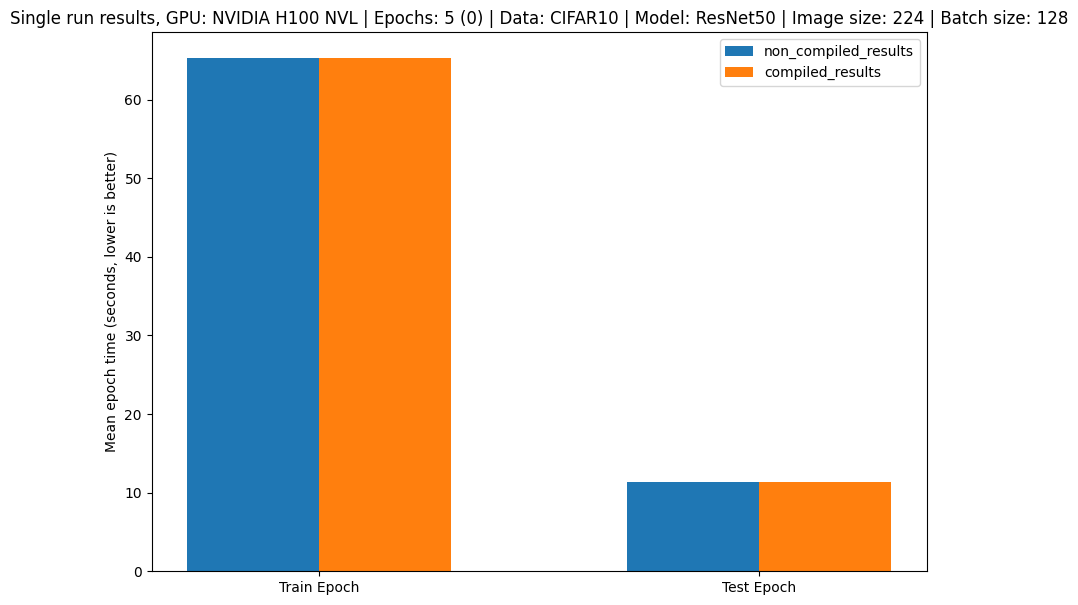

In [36]:
from pathlib import Path
dir_to_save_image_in = Path("pytorch2_results/figures")

dir_to_save_image_in.mkdir(parents=True, exist_ok=True)

save_path_single_run = dir_to_save_image_in / Path(f"single_run_{GPU_NAME}_{DATASET_NAME}_{IMAGE_SIZE}_train_epoch_time.png")
print(f"[INFO] Save path for single run results: {save_path_single_run}")

plot_mean_epoch_times(non_compiled_results=single_run_no_compile_results_df,
                      compiled_results=single_run_compile_results_df,
                      multi_runs=False,
                      save_path=save_path_single_run,
                      save=True)